In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rc
from sklearn.metrics import r2_score
rc('font', family = 'AppleGothic')

In [40]:
data = pd.read_csv("oecd_family.csv")
#합계출산율(Total fertility rate) 추출
birth_rate = data.loc[(data.IND=='FAM1',['Country', 'Year','Value'])]

#2021년 이상 데이터 삭제
birth_rate = birth_rate.drop(birth_rate.loc[birth_rate.Year>=2021].index)

#2012년부터 2020년까지 출산율 결측치 없음
birth_rate.isna().sum()

#인덱스 재정렬
birth_rate.index = range(0,len(birth_rate))

#한글화를 위한 리스트 생성
CountryName = ["이스라엘","룩셈부르크","네덜란드","그리스","아이슬란드","라트비아","슬로베니아","프랑스","폴란드","튀르키예","스페인","벨기에","멕시코","아일랜드","스위스","핀란드","칠레","캐나다","대한민국","뉴질랜드","오스트레일리아","헝가리","미국","영국","오스트리아","스웨덴","덴마크","슬로바키아","체코","콜롬비아","일본","노르웨이","코스타리카","리투아니아","독일","에스토니아","포르투갈","이탈리아"]

#영어이름을 한글로
for i in range(0,38):
    for j in range(0,9):
        birth_rate.loc[i*9:i*9+j,"Country"] = CountryName[i]
        
birth_rate

,Country,Year,Value
0,이스라엘,2012,3.05
1,이스라엘,2013,3.03
2,이스라엘,2014,3.08
3,이스라엘,2015,3.09
4,이스라엘,2016,3.11
...,...,...,...
337,이탈리아,2016,1.36
338,이탈리아,2017,1.34
339,이탈리아,2018,1.31
340,이탈리아,2019,1.27


In [41]:
#경제활동인구(여자)중 경제활동 참가율 data
df2 = pd.read_csv("경제활동인구 및 참가율(OECD).csv", encoding= "euc-kr", skiprows = 1)
plt.rcParams['font.family'] = 'NanumGothicOTF'

#column(열) 이름 바꾸기 = 연도
    
df2= df2.rename(columns = {'여자 (%)' : '2012'})
for i in range(1,10):
    df2 = df2.rename(columns = {'여자 (%).{}'.format(i): str(2012+i)} )

namelist = []
#row(행) 이름 바꾸기. = 국가    
for i in range(len(df2)):
    x = df2.loc[i,'국가별'].find("(")
    name = df2.loc[i,'국가별']
    if(x != -1):
        name = name[:x]
        namelist.append(name)
        df2.rename(index = {i :name},inplace = True)
    else:
        df2.rename(index = {i :name},inplace = True)


#필요한 데이터만 추출.
col_name = []
for i in range(2012,2021):
    col_name.append(str(i))

rate_df = df2[col_name]

#NaN 값 제거.
rate_df.drop(rate_df.index[0], inplace= True)
rate_df.dropna(inplace=True)
rate_df.head()

#빈값 찾기.
col = rate_df.columns.values

index = rate_df.index.values
outlier = {}
for i in index:
    for c in col:
        if (rate_df.loc[i,str(c)] == '-'):
            outlier[c] = i

#국가별 평균값으로 빈값 찾기.
sum = 0
for key in outlier.keys():
    sum = 0
    for c in col:
        if (c == key):
            continue
        else:
            sum += float(rate_df.loc[outlier.get(key),str(c)])
    rate_df.loc[outlier.get(key), key] = round(sum/(len(col)-len(outlier)),1)

country = []
year = []
value = []
rate_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    rate_val.append(float(rate_df[str(year[i])][country[i]]))

# 전처리 완료한 데이터.
rate_df = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'rate_val' : rate_val
})

/var/folders/ls/8g_ybb8s6493dzrgbbh9shjc0000gn/T/ipykernel_82693/2645756960.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df.drop(rate_df.index[0], inplace= True)
/var/folders/ls/8g_ybb8s6493dzrgbbh9shjc0000gn/T/ipykernel_82693/2645756960.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df.dropna(inplace=True)


In [42]:
#gdp 데이터
df = pd.read_csv("OECD 국가의 주요지표.csv", encoding= "euc-kr", skiprows = 1)

#column(열) 이름 바꾸기 = 연도
df= df.rename(columns = {'국내총생산(GDP)(당해년 가격) (10억US$)' : '2012'})

for i in range(1,10):
    df = df.rename(columns = {'국내총생산(GDP)(당해년 가격) (10억US$).{}'.format(i): str(2012+i)} )

#row(행) 이름 바꾸기. = 국가
for i in range(len(df)):
    df.rename(index = {i :df.loc[i,'국가별']},inplace = True)

#필요한 GDP 데이터만 데이터프레임으로 추출.
#column 이름으로 추출.
col_name = []
for i in range(2012,2021):
    col_name.append(str(i))

GDP_df = df[col_name]

#NaN 값 제거.
GDP_df.drop(GDP_df.index[0], inplace= True)
GDP_df.dropna(inplace=True)

#OECD 총값 제거.
GDP_df.drop(GDP_df.tail(1).index,inplace=True)
#빈값, 잘못된 값 찾기
col = GDP_df.columns.values

index = GDP_df.index.values
outlier = {}
for i in index:
    for c in col:
        if (GDP_df.loc[i,str(c)] == '-'):
            outlier[c] = i
#빈값, 잘못된 값을 각 국의 평균값으로 대체.
sum = 0
for key in outlier.keys():
    sum = 0
    for c in col:
        if (c == key):
            continue
        else:
            sum += float(GDP_df.loc[outlier.get(key),str(c)])
    GDP_df.loc[outlier.get(key), key] = round(sum/(len(col)-len(outlier)),1)

country = []
year = []
value = []
gdp_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    gdp_val.append(float(GDP_df[str(year[i])][country[i]]))
    
#전처리 완료한 데이터.
gdp_df = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'gdp_val' : gdp_val
})

gdp_df

/var/folders/ls/8g_ybb8s6493dzrgbbh9shjc0000gn/T/ipykernel_82693/1515712362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GDP_df.drop(GDP_df.index[0], inplace= True)
/var/folders/ls/8g_ybb8s6493dzrgbbh9shjc0000gn/T/ipykernel_82693/1515712362.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GDP_df.dropna(inplace=True)
/var/folders/ls/8g_ybb8s6493dzrgbbh9shjc0000gn/T/ipykernel_82693/1515712362.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

,Country,Year,gdp_val
0,대한민국,2012,1278.0
1,대한민국,2013,1370.6
2,대한민국,2014,1484.0
3,대한민국,2015,1465.3
4,대한민국,2016,1500.0
...,...,...,...
337,뉴질랜드,2016,188.9
338,뉴질랜드,2017,207.0
339,뉴질랜드,2018,212.2
340,뉴질랜드,2019,209.1


In [43]:
#성불평등지수
inequality = pd.read_csv("sex_inequality.csv")
inequality = inequality.set_index('국가별')
inequality = inequality.drop(['대륙'], axis=1)

country = []
year = []
value = []
inequality_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    inequality_val.append(float(inequality[str(year[i])][country[i]]))

# 전처리 완료한 데이터.
inequality = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'inequality_val' : inequality_val
})
inequality

,Country,Year,inequality_val
0,대한민국,2012,0.108
1,대한민국,2013,0.108
2,대한민국,2014,0.100
3,대한민국,2015,0.096
4,대한민국,2016,0.086
...,...,...,...
337,뉴질랜드,2016,0.126
338,뉴질랜드,2017,0.112
339,뉴질랜드,2018,0.102
340,뉴질랜드,2019,0.100


In [52]:
totaldf = pd.merge(birth_rate, rate_df, on = ['Country','Year'])
totaldf = pd.merge(totaldf, gdp_df, on = ['Country','Year'])
totaldf = pd.merge(totaldf, inequality, on = ['Country','Year'])
totaldf

,Country,Year,Value,rate_val,gdp_val,inequality_val
0,이스라엘,2012,3.05,58.1,257.2,0.131
1,이스라엘,2013,3.03,58.2,292.7,0.117
2,이스라엘,2014,3.08,59.2,310.0,0.114
3,이스라엘,2015,3.09,59.1,300.1,0.104
4,이스라엘,2016,3.11,59.4,318.6,0.101
...,...,...,...,...,...,...
337,이탈리아,2016,1.36,40.5,1875.8,0.075
338,이탈리아,2017,1.34,40.9,1957.0,0.070
339,이탈리아,2018,1.31,41.1,2091.1,0.057
340,이탈리아,2019,1.27,41.3,2004.9,0.054


In [53]:
def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    # print('IQR은',iqr, '이다.')     
    # print('lower bound 값은', lower, '이다.')     
    # print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 인덱스 각각 저장하기     
    data1 = data[data[column] > upper].index     
    data2 = data[data[column] < lower].index    
    
    data.drop(data1, inplace = True)
    data.drop(data2, inplace = True)
    
    # 이상치 총 개수 구하기
#     print(data1.shape[0])
#     print(data2.shape[0])
    
#     print(data1)
    return data
    # return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')



In [54]:
outlier_iqr(totaldf, 'inequality_val')
outlier_iqr(totaldf, 'rate_val')
outlier_iqr(totaldf, 'Value')
outlier_iqr(totaldf, 'gdp_val')
totaldf

,Country,Year,Value,rate_val,gdp_val,inequality_val
9,룩셈부르크,2012,1.57,51.9,56.7,0.093
10,룩셈부르크,2013,1.55,52.5,61.7,0.072
11,룩셈부르크,2014,1.50,53.4,66.1,0.071
12,룩셈부르크,2015,1.47,54.6,57.7,0.067
13,룩셈부르크,2016,1.41,53.5,60.7,0.063
...,...,...,...,...,...,...
330,포르투갈,2018,1.41,54.5,242.2,0.074
331,포르투갈,2019,1.42,54.8,239.5,0.071
332,포르투갈,2020,1.40,53.6,231.3,0.069
339,이탈리아,2018,1.31,41.1,2091.1,0.057


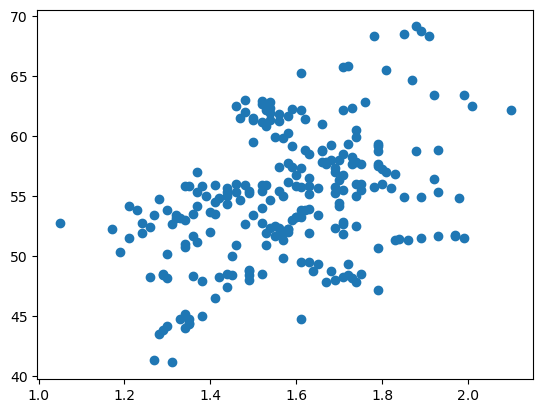

In [56]:
plt.scatter(totaldf['Value'], totaldf['rate_val'])

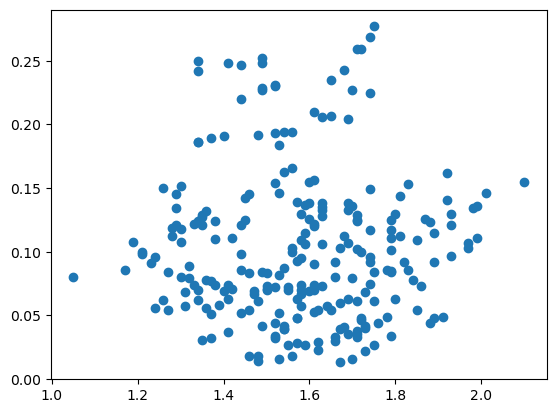

In [65]:
plt.scatter(totaldf['Value'], totaldf['inequality_val'])

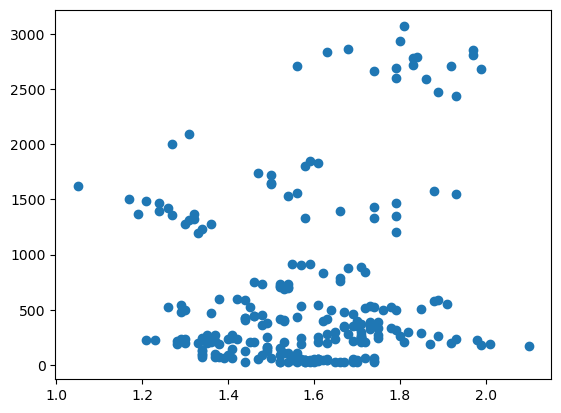

In [61]:
plt.scatter(totaldf['Value'], totaldf['gdp_val'])

In [59]:
x = totaldf['Value']
y = totaldf['rate_val']
stats.pearsonr(x,y)

(0.42379487366565827, 4.694764752763843e-12)

In [60]:
x = totaldf['Value']
y = totaldf['gdp_val']
stats.pearsonr(x,y)

(0.1761952396276931, 0.0057845928820616415)

In [63]:
x = totaldf['Value']
y = totaldf['inequality_val']
stats.pearsonr(x,y)

(0.000324852603996598, 0.9959720542414177)